In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN, 
    one_hot_from_int, 
    truncated_noise_sample)
import time
import torchvision.utils as vutils
import torch.optim as optim
import torch.nn as nn
from PIL import Image
import numpy as np
import IPython.display
import cv2

In [134]:
G = BigGAN.from_pretrained('biggan-deep-256')
if torch.cuda.device_count() > 1:
    print('Using {} gpus for G'.format(torch.cuda.device_count()))
    G = torch.nn.DataParallel(G)
G.to('cuda')

BigGAN(
  (embeddings): Linear(in_features=1000, out_features=128, bias=False)
  (generator): Generator(
    (gen_z): Linear(in_features=256, out_features=32768, bias=True)
    (layers): ModuleList(
      (0): GenBlock(
        (bn_0): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=2048, bias=False)
          (offset): Linear(in_features=256, out_features=2048, bias=False)
        )
        (conv_0): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))
        (bn_1): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_2): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_2): Conv2d(512, 512, kernel_size=(3, 

In [125]:
import io
import PIL
import sys
sys.path.append('./rotate_3d')
from image_transformer import ImageTransformer
    
def imshow(a, format='png', jpeg_fallback=True, filename=None):
  a = np.asarray(a, dtype=np.uint8)
  str_file = io.BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
    if filename:
        size = (a.shape[1]//2, a.shape[0]//2)
        im = PIL.Image.fromarray(a)
        im.thumbnail(size,PIL.Image.ANTIALIAS)
        im.save('{}.{}'.format(filename, format))
        
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def imshow_unscaled(target, return_img=False):
  np_target = target
  np_target_scaled = np.clip(((np_target + 1) / 2.0) * 256, 0, 255)
  im = np.concatenate(np_target_scaled, axis=0)
  imshow(np.uint8(im))
  if return_img:
      return im

    
## Define our edit fns
class Rot3dTransform:    
    def __init__(self, alpha_max=60):
        self.alpha_max = alpha_max
            
    def get_alphas(self, batch_size):
        ''' get an alpha for training, return in format
        alpha_val_for_graph, alpha_val_for get_target_np'''
        alphas = np.expand_dims(np.random.choice(np.arange(-self.alpha_max, self.alpha_max+10, 10), 
                                                    batch_size), axis=1)
        # graph and target use the same slider value
        alphas_target = alphas
        alphas_graph = alphas/self.alpha_max
        return alphas_target, alphas_graph
    
    def get_target(self, outputs_zs, alpha_batch, show_img=False, show_mask=False):
        assert alpha_batch.shape[1] == 1
        assert outputs_zs.shape[0] == alpha_batch.shape[0]
        assert isinstance(outputs_zs, np.ndarray)
        if not np.any(alpha_batch):
            mask_fn = np.ones(outputs_zs.shape)
            return outputs_zs, mask_fn

        outputs_zs = outputs_zs.transpose(0, 2, 3, 1)
        mask_fn = np.ones(outputs_zs.shape)

        target_fn = np.zeros(outputs_zs.shape)
        mask_out = np.zeros(outputs_zs.shape)
        for i in range(outputs_zs.shape[0]):
            alpha = alpha_batch[i][0]
            it = ImageTransformer(outputs_zs[i,:,:,:], shape=None)
            target_fn[i,:,:,:] = it.rotate_along_axis(phi = alpha, dx = -alpha/5)
            it = ImageTransformer(mask_fn[i,:,:,:], shape=None)
            mask_out[i,:,:,:] = it.rotate_along_axis(phi = alpha, dx = -alpha/5)

        if show_img:
            print('Target image:')
            imshow_unscaled(target_fn)
        if show_mask:
            print('Target mask:')
            imshow_unscaled(mask_out)

        target_fn = target_fn.transpose(0, 3, 1, 2)
        mask_out = mask_out.transpose(0, 3, 1, 2)
        return target_fn, mask_out

    
class Rot2dTransform:    
    def __init__(self, alpha_max=30):
        self.alpha_max = alpha_max
            
    def get_alphas(self, batch_size):
        ''' get an alpha for training, return in format
        alpha_val_for_graph, alpha_val_for get_target_np'''
        alphas = np.expand_dims(np.random.choice(np.arange(-self.alpha_max, self.alpha_max+5, 5), 
                                                    batch_size), axis=1)
        # graph and target use the same slider value
        alphas_target = alphas
        alphas_graph = alphas/self.alpha_max
        return alphas_target, alphas_graph

    def get_target(self, outputs_zs, mask_fn, alpha_batch, show_img=False, show_mask=False):  
        assert alpha_batch.shape[1] == 1
        assert outputs_zs.shape[0] == mask_fn.shape[0] == alpha_batch.shape[0]
        assert isinstance(outputs_zs, np.ndarray)
        if not np.any(alpha_batch):
            return outputs_zs, mask_fn

        outputs_zs = outputs_zs.transpose(0, 2, 3, 1)
        mask_fn = np.ones(outputs_zs.shape)

        target_fn = np.zeros(outputs_zs.shape)
        mask_out = np.zeros(outputs_zs.shape)
        img_size = target_fn.shape[1]
        for i in range(outputs_zs.shape[0]):
            degree = alpha_batch[i][0] 
            M = cv2.getRotationMatrix2D((img_size//2, img_size//2), degree, 1)
            target_fn[i,:,:,:] = cv2.warpAffine(outputs_zs[i,:,:,:], M, (img_size, img_size))
            mask_out[i,:,:,:] = cv2.warpAffine(mask_fn[i,:,:,:], M, (img_size, img_size))

        mask_out[np.nonzero(mask_out)] = 1.
        assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)

        if show_img:
            print('Target image:')
            imshow_unscaled(target_fn)
        if show_mask:
            print('Target mask:')
            imshow_unscaled(mask_out)
            
        target_fn = target_fn.transpose(0, 3, 1, 2)
        mask_out = mask_out.transpose(0, 3, 1, 2)
        return target_fn, mask_out

    
class ZoomShiftXYTransform:    
    def __init__(self, alpha_max_zoom=4.0, alpha_max_shift=100):
        self.alpha_max_zoom = alpha_max_zoom
        self.alpha_max_shift = alpha_max_shift

    def get_alphas(self, batch_size):
        ''' get an alpha for training, return in format
        alpha_val_for_graph, alpha_val_for get_target_np'''
        
        alphas_shiftx_target = np.expand_dims(np.random.choice(np.arange(-self.alpha_max_shift, self.alpha_max_shift+10, 10), 
                                                           batch_size), axis=1)
        alphas_shiftx_graph = alphas_shiftx_target / self.alpha_max_shift
        
        alphas_shifty_target = np.expand_dims(np.random.choice(np.arange(-self.alpha_max_shift, self.alpha_max_shift+10, 10), 
                                                           batch_size), axis=1)
        alphas_shifty_graph = alphas_shifty_target / self.alpha_max_shift
        
        
        alphas_zoom_target = np.ones((batch_size, 1))
        alphas_zoom_graph = np.ones((batch_size, 1))
        for b in range(batch_size):            
            coin = np.random.uniform(0, 1)
            if coin <= 0.5:
                alpha_val = np.random.uniform(np.log(self.alpha_max_zoom), 1.)
            else:
                alpha_val = np.random.uniform(1., self.alpha_max_zoom)
            alphas_zoom_target[b,0] = alpha_val
            alphas_zoom_graph[b,0] = np.log(alpha_val)
        
        return [alphas_zoom_target, alphas_zoom_graph, alphas_shiftx_target, alphas_shiftx_graph, alphas_shifty_target, alphas_shifty_graph]
            
    def get_target(self, outputs_zs, mask_fn, alpha_batch_zoom, alpha_batch_shift_x, alpha_batch_shift_y, 
                   show_img=False, show_mask=False):
        assert alpha_batch_zoom.shape[1] == 1
        assert outputs_zs.shape[0] == mask_fn.shape[0] == alpha_batch_zoom.shape[0]
        assert(alpha_batch_zoom.shape == alpha_batch_shift_x.shape == alpha_batch_shift_y.shape)
        assert isinstance(outputs_zs, np.ndarray)

        outputs_zs = outputs_zs.transpose(0, 2, 3, 1)
        mask_fn = np.ones(outputs_zs.shape)

        target_fn = np.zeros(outputs_zs.shape)
        mask_out = np.zeros(outputs_zs.shape)
        img_size = target_fn.shape[1]

        for i in range(outputs_zs.shape[0]):
            alpha_zoom = alpha_batch_zoom[i][0]
            new_size = int(alpha_zoom*img_size)
            output_cropped = np.zeros((new_size, new_size, outputs_zs.shape[3]))
            mask_cropped = np.zeros((new_size, new_size, outputs_zs.shape[3]))
            ## crop
            if alpha_zoom < 1:
                output_cropped = outputs_zs[i,img_size//2-new_size//2:img_size//2+new_size//2, img_size//2-new_size//2:img_size//2+new_size//2,:]
                mask_cropped = mask_fn[i,img_size//2-new_size//2:img_size//2+new_size//2, img_size//2-new_size//2:img_size//2+new_size//2,:]
            ## padding
            else:
                output_cropped[new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = outputs_zs[i] 
                mask_cropped[new_size//2-img_size//2:new_size//2+img_size//2, new_size//2-img_size//2:new_size//2+img_size//2,:] = mask_fn[i]

            ## Resize
            target_fn[i,:,:,:] = cv2.resize(output_cropped, (img_size, img_size), interpolation = cv2.INTER_LINEAR)
            mask_out[i,:,:,:] = cv2.resize(mask_cropped, (img_size, img_size), interpolation = cv2.INTER_LINEAR)

            # shift x and y:
            M = np.float32([[1,0,alpha_batch_shift_x[i][0]],[0,1,alpha_batch_shift_y[i][0]]])
            target_fn[i,:,:,:] = cv2.warpAffine(target_fn[i,:,:,:], M, (img_size, img_size))
            mask_out[i,:,:,:] = cv2.warpAffine(mask_out[i,:,:,:], M, (img_size, img_size))

        mask_out[np.nonzero(mask_out)] = 1.
        assert(np.setdiff1d(mask_out, [0., 1.]).size == 0)

        if show_img:
            print('Target image:')
            imshow_unscaled(target_fn)
        if show_mask:
            print('Target mask:')
            imshow_unscaled(mask_out)
            
        target_fn = target_fn.transpose(0, 3, 1, 2)
        mask_out = mask_out.transpose(0, 3, 1, 2)
        return target_fn, mask_out
    

class ColorTransform:
    def __init__(self, alpha_max=0.5, num_channels=3):
        self.alpha_max = alpha_max
        self.num_channels = num_channels
        
    def get_alphas(self, batch_size):
        ''' get an alpha for training, return in format
        alpha_val_for_graph, alpha_val_for get_target_np'''
        alphas = np.random.random(size=(batch_size, self.num_channels))-self.alpha_max
        # graph and target use the same slider value
        alphas_target = alphas
        alphas_graph = alphas
        return alphas_target, alphas_graph

    def get_target(self, outputs_zs, alpha_batch, show_img=False, show_mask=False):
        assert alpha_batch.shape[1] == 3
        assert(outputs_zs.shape[0] == alpha_batch.shape[0])
        assert isinstance(outputs_zs, np.ndarray)
        if not np.any(alpha_batch): # alpha is all zeros
            return outputs_zs, np.ones(outputs_zs.shape)

        outputs_zs = outputs_zs.transpose(0, 2, 3, 1)

        target_fn = np.copy(outputs_zs)
        for b in range(outputs_zs.shape[0]):
            for i in range(self.num_channels):
                target_fn[b,:,:,i] = target_fn[b,:,:,i]+alpha_batch[b,i]

        mask_out = np.ones(outputs_zs.shape)

        if show_img:
            print('Target image:')
            imshow_unscaled(target_fn)
        if show_mask:
            print('Target mask:')
            imshow_unscaled(mask_out)
            
        target_fn = target_fn.transpose(0, 3, 1, 2)
        mask_out = mask_out.transpose(0, 3, 1, 2)
        return target_fn, mask_out

In [ ]:
## Lets check transformations
truncation = 1.0
num_samples = 4
batch_size = num_samples

for batch_num in range(num_samples // batch_size):
    # latents
    zs = truncated_noise_sample(truncation=truncation, batch_size=batch_size, seed=None)
    zs = torch.from_numpy(zs).to('cuda')
    # labels
    ys = one_hot_from_int(np.random.choice(1000, batch_size), batch_size)
    ys = torch.from_numpy(ys).to('cuda')
    # transforms
    # 3D
    rot3d_transform = Rot3dTransform()
    alphas_rot3d_target, alphas_rot3d_graph = rot3d_transform.get_alphas(batch_size)
    # 2D
    rot2d_transform = Rot2dTransform()
    alphas_rot2d_target, alphas_rot2d_graph = rot2d_transform.get_alphas(batch_size)
    # Zoom, shiftx, shifty
    zxy_transform = ZoomShiftXYTransform()
    alphas_zxy = zxy_transform.get_alphas(batch_size)
    # Color
    color_transform = ColorTransform()
    alphas_color_target, alphas_color_graph = color_transform.get_alphas(batch_size)

    with torch.no_grad():
        out_im = G(zs, ys, truncation)

    # get composed target
    color_target, color_mask = color_transform.get_target(out_im.cpu().numpy(), alphas_color_target, show_img=True, show_mask=True)
    rot3d_target, rot3d_mask = rot3d_transform.get_target(color_target, alphas_rot3d_target, show_img=True, show_mask=True)
    rot2d_target, rot2d_mask = rot2d_transform.get_target(rot3d_target, rot3d_mask, alphas_rot2d_target, show_img=True, show_mask=True)
    targets, masks = zxy_transform.get_target(rot2d_target, rot2d_mask, alphas_zxy[0], alphas_zxy[2], alphas_zxy[4], show_img=True, show_mask=True)
    numel_masks = np.count_nonzero(masks)


In [ ]:
# training parameters
dim_z = truncated_noise_sample(truncation=0.1, batch_size=1).shape[1]
learning_rate = 0.001 # you can also try changing this as well

w_rot3d = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z]),  
                 device='cuda', dtype=torch.float32, requires_grad=True)
w_rot2d = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z]),  
                 device='cuda', dtype=torch.float32, requires_grad=True)
w_zoom = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z]),  
                 device='cuda', dtype=torch.float32, requires_grad=True)
w_shiftx = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z]),  
                 device='cuda', dtype=torch.float32, requires_grad=True)
w_shifty = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z]),  
                 device='cuda', dtype=torch.float32, requires_grad=True)
w_color = torch.tensor(np.random.normal(0.0, 0.1, [1, dim_z, color_transform.num_channels]),  
                 device='cuda', dtype=torch.float32, requires_grad=True)
# loss function and optimizer
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam([w_rot3d, w_rot2d, w_zoom, w_shiftx, w_shifty, w_color], lr=learning_rate)

In [ ]:
# training
num_samples = 40000
truncation = 1.0
loss_sum = 0
optim_iter = 0
batch_size = 4
loss_values = []
save_freq = 1000 # frequency to save weights

# train loop
for batch_num in range(num_samples // batch_size):
    start_time = time.time()
  
    # 1. sample z and y randomly
    # latents
    zs = truncated_noise_sample(truncation=truncation, batch_size=batch_size, seed=None)
    zs = torch.from_numpy(zs).to('cuda')
    # labels
    ys = one_hot_from_int(np.random.choice(1000, batch_size), batch_size)
    ys = torch.from_numpy(ys).to('cuda')
    # transforms
    # 3D
    rot3d_transform = Rot3dTransform()
    alphas_rot3d_target, alphas_rot3d_graph = rot3d_transform.get_alphas(batch_size)
    alphas_rot3d_graph = torch.tensor(alphas_rot3d_graph, device='cuda', dtype=torch.float32)
    # 2D
    rot2d_transform = Rot2dTransform()
    alphas_rot2d_target, alphas_rot2d_graph = rot2d_transform.get_alphas(batch_size)
    alphas_rot2d_graph = torch.tensor(alphas_rot2d_graph, device='cuda', dtype=torch.float32)
    # Zoom, shiftx, shifty
    zxy_transform = ZoomShiftXYTransform()
    alphas_zxy = zxy_transform.get_alphas(batch_size)
    alphas_zoom_graph = torch.tensor(alphas_zxy[1], device='cuda', dtype=torch.float32)
    alphas_shiftx_graph = torch.tensor(alphas_zxy[3], device='cuda', dtype=torch.float32)
    alphas_shifty_graph = torch.tensor(alphas_zxy[5], device='cuda', dtype=torch.float32)
    # Color
    color_transform = ColorTransform()
    alphas_color_target, alphas_color_graph = color_transform.get_alphas(batch_size)
    alphas_color_graph = torch.tensor(alphas_color_graph, device='cuda', dtype=torch.float32)

    with torch.no_grad():
        out_im = G(zs, ys, truncation)

    # get composed target
    color_target, color_mask = color_transform.get_target(out_im.cpu().numpy(), alphas_color_target)
    rot3d_target, rot3d_mask = rot3d_transform.get_target(color_target, alphas_rot3d_target)
    rot2d_target, rot2d_mask = rot2d_transform.get_target(rot3d_target, rot3d_mask, alphas_rot2d_target)
    targets, masks = zxy_transform.get_target(rot2d_target, rot2d_mask, alphas_zxy[0], alphas_zxy[2], alphas_zxy[4])
    numel_masks = np.count_nonzero(masks)

    targets_tensor = torch.tensor(targets, device='cuda', dtype=torch.float32)
    masks_tensor = torch.tensor(masks, device='cuda', dtype=torch.float32)
    numel_masks_tensor = torch.tensor(numel_masks, device='cuda', dtype=torch.float32)
  
    # forward pass
    optimizer.zero_grad()
    z_new = zs + alphas_rot3d_graph * w_rot3d + alphas_rot2d_graph * w_rot2d + \
            alphas_zoom_graph * w_zoom + alphas_shiftx_graph * w_shiftx + alphas_shifty_graph * w_shifty
    for i in range(color_transform.num_channels):
        z_new = z_new + alphas_color_graph[:,i].unsqueeze(1) * w_color[:,:,i]
        
    out_im = G(z_new, ys, truncation)
    # mean over unmasked regions in the target
    loss = criterion(out_im * masks_tensor, targets_tensor * masks_tensor) / numel_masks_tensor
  
    # 4. optimize loss 
    loss.backward()
    optimizer.step()
  
    loss_values.append(loss)
    loss_sum += loss
    elapsed_time = time.time() - start_time
  
    print('Time:{}, batch_start:{}, loss:{}'.format(elapsed_time, batch_num * batch_size, loss))
 
    # save intermediate walk
    if (optim_iter % save_freq == 0) and (optim_iter > 0):
        torch.save({'walk_color': w_color, 'walk_rot3d': w_rot3d, 'walk_rot2d': w_rot2d, 
                    'walk_zoom': w_zoom, 'walk_shiftx': w_shiftx, 'walk_shifty': w_shifty}, 
                   'walk_weights_biggan_deep/w_composed_{}.pth'.format(optim_iter * batch_size))
  
    optim_iter += 1
  
print('average loss with this metric: ', loss_sum/(optim_iter*batch_size))
torch.save({'walk_color': w_color, 'walk_rot3d': w_rot3d, 'walk_rot2d': w_rot2d, 
            'walk_zoom': w_zoom, 'walk_shiftx': w_shiftx, 'walk_shifty': w_shifty}, 
           'walk_weights_biggan_deep/w_composed_final.pth')

In [133]:
# load pretrained walk
walk_composed_final_path = ('./walk_weights_biggan_deep/w_composed_160k_lr0.001_final.pth')
walk_composed_final = torch.load(walk_composed_final_path)
walk_color = walk_composed_final['walk_color'].to('cuda')
walk_rot3d = walk_composed_final['walk_rot3d'].to('cuda')
walk_rot2d = walk_composed_final['walk_rot2d'].to('cuda')
walk_zoom = walk_composed_final['walk_zoom'].to('cuda')
walk_shiftx = walk_composed_final['walk_shiftx'].to('cuda')
walk_shifty = walk_composed_final['walk_shifty'].to('cuda')

torch.Size([10, 128])
torch.Size([10, 128])
torch.Size([10, 128])
G(z):


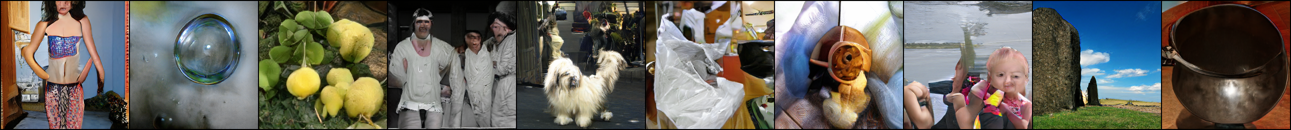

Composed targets:


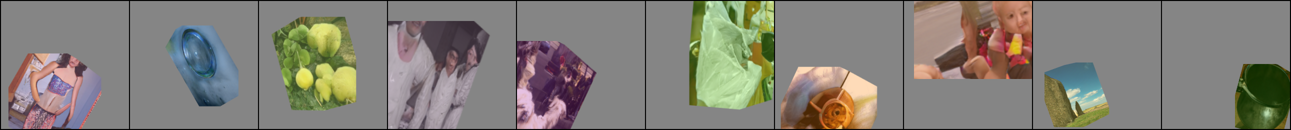

G(z+walks)


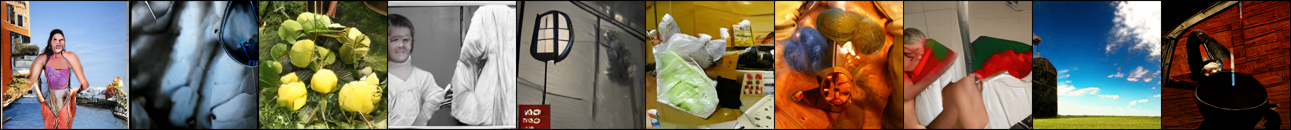

In [135]:
## Lets check what learned
truncation = 1.0
num_samples = 10
batch_size = num_samples

for batch_num in range(num_samples // batch_size):
    # latents
    zs = truncated_noise_sample(truncation=truncation, batch_size=batch_size, seed=None)
    zs = torch.from_numpy(zs).to('cuda')
    # labels
    ys = one_hot_from_int(np.random.choice(1000, batch_size), batch_size)
#     ys = one_hot_from_int(207, batch_size)
    ys = torch.from_numpy(ys).to('cuda')
    # transforms
    # 3D
    rot3d_transform = Rot3dTransform()
    alphas_rot3d_target, alphas_rot3d_graph = rot3d_transform.get_alphas(batch_size)
#     alphas_rot3d_target *= 0
#     alphas_rot3d_graph *= 0.0
    alphas_rot3d_graph = torch.tensor(alphas_rot3d_graph, device='cuda', dtype=torch.float32)
    # 2D
    rot2d_transform = Rot2dTransform()
    alphas_rot2d_target, alphas_rot2d_graph = rot2d_transform.get_alphas(batch_size)
#     alphas_rot2d_target *= 0
#     alphas_rot2d_graph *= 0.0
    alphas_rot2d_graph = torch.tensor(alphas_rot2d_graph, device='cuda', dtype=torch.float32)
    # Zoom, shiftx, shifty
#     zxy_transform = ZoomShiftXYTransform(alpha_max_zoom=2.0)
    zxy_transform = ZoomShiftXYTransform(alpha_max_zoom=2.0)
    alphas_zxy = zxy_transform.get_alphas(batch_size)
#     alphas_zxy[0] = np.ones(alphas_zxy[0].shape)
#     alphas_zxy[1] *= 0.0
#     alphas_zxy[2] *= 0
#     alphas_zxy[3] *= 0.0
#     alphas_zxy[4] *= 0
#     alphas_zxy[5] *= 0.0
    alphas_zoom_graph = torch.tensor(alphas_zxy[1], device='cuda', dtype=torch.float32)
    alphas_shiftx_graph = torch.tensor(alphas_zxy[3], device='cuda', dtype=torch.float32)
    alphas_shifty_graph = torch.tensor(alphas_zxy[5], device='cuda', dtype=torch.float32)
    # Color
    color_transform = ColorTransform()
    alphas_color_target, alphas_color_graph = color_transform.get_alphas(batch_size)
#     alphas_color_target *=0
#     alphas_color_graph *=0.0
    alphas_color_graph = torch.tensor(alphas_color_graph, device='cuda', dtype=torch.float32)

    with torch.no_grad():
        out_im = G(zs, ys, truncation)

    # get composed target
    color_target, color_mask = color_transform.get_target(out_im.cpu().numpy(), alphas_color_target)
    rot3d_target, rot3d_mask = rot3d_transform.get_target(color_target, alphas_rot3d_target)
    rot2d_target, rot2d_mask = rot2d_transform.get_target(rot3d_target, rot3d_mask, alphas_rot2d_target)
    targets, masks = zxy_transform.get_target(rot2d_target, rot2d_mask, alphas_zxy[0], alphas_zxy[2], alphas_zxy[4])

    z_new = zs
    for i in range(color_transform.num_channels):
        z_new = z_new + alphas_color_graph[:,i].unsqueeze(1) * walk_color[:,:,i]
    z_new = z_new + 5*alphas_rot3d_graph * walk_rot3d + alphas_rot2d_graph * walk_rot2d + \
            alphas_zoom_graph * walk_zoom + alphas_shiftx_graph * walk_shiftx + alphas_shifty_graph * walk_shifty
    
    with torch.no_grad():
        out_im_transformed = G(z_new, ys, truncation)
        
    # show G(z)
    print('G(z):')
    image_grid = vutils.make_grid(out_im, nrow=batch_size, normalize=True)
    image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
    image_grid_np = np.uint8(image_grid_np)
    IPython.display.display(Image.fromarray(image_grid_np).resize(
        (image_grid_np.shape[1]//2, image_grid_np.shape[0]//2)))
    
    # show final targets:
    print('Composed targets:')
    targets_tensor = torch.from_numpy(targets)
    masks_tensor = torch.from_numpy(masks)
    image_grid = vutils.make_grid(targets_tensor, nrow=batch_size, normalize=True)
    image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
    image_grid_np = np.uint8(image_grid_np)
    IPython.display.display(Image.fromarray(image_grid_np).resize(
        (image_grid_np.shape[1]//2, image_grid_np.shape[0]//2)))

    # show transformed G(z)
    print('G(z+walks)')
    image_grid = vutils.make_grid(out_im_transformed, nrow=batch_size, normalize=True)
    image_grid_np = image_grid.cpu().numpy().transpose(1, 2, 0) * 255
    image_grid_np = np.uint8(image_grid_np)
    IPython.display.display(Image.fromarray(image_grid_np).resize(
        (image_grid_np.shape[1]//2, image_grid_np.shape[0]//2)))